In [1]:
import numpy as np
import pandas as pd 
import random
import os
import tensorflow as tf
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Input, MaxPooling2D, concatenate, Conv2DTranspose
import tqdm

In [2]:
input_files = []
files=[]
for dirname, _, filenames in os.walk('/kaggle/input/xray-bone-shadow-supression/augmented/augmented/source'):
    for filename in filenames:
        files.append(filename)
      
num_files = len(files)
print(num_files)

random.shuffle(files)

training_files = files[:int(num_files*.8)]
validation_files = files[int(num_files*.8):int(num_files*.9)]
test_files = files[int(num_files*.9):]

print(len(training_files) + len(validation_files) + len(test_files))

4080
4080


In [3]:
def dataGrab(input_path,output_path,files):
    input = []
    for file in tqdm.tqdm(files):
        im = Image.open(os.path.join(input_path,file))
        im = im.resize((256,256))
        data = np.asarray(im).astype('float32')/255.0
        input.append(data)
             
    output = []
    for file in tqdm.tqdm(files):
        im = Image.open(os.path.join(output_path,file))
        im = im.resize((256,256))
        data = np.asarray(im).astype('float32')/255.0
        output.append(data)
    
    return input, output
            
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self,files,input_path,output_path,batch_size = 32):
        self.files = files
        self.batch_size = batch_size
        self.input_path = input_path
        self.output_path  = output_path
        self.indexes = np.arange(len(self.files))
        
        self.input_data,self.output_data = dataGrab(self.input_path,self.output_path,self.files)
        
        
    def __len__(self):
        return int(np.floor(len(self.files)/self.batch_size))
    
    def on_epoch_end(self):
        random.shuffle(self.indexes)
        
    def __getitem__(self,index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        X = np.zeros((self.batch_size,256,256,1))
        y = np.zeros((self.batch_size,256,256,1))
        
        for i, ID in enumerate(indexes):
            X[i,:,:,0] = self.input_data[ID]
            y[i,:,:,0] = self.output_data[ID]
            
        return X,y

In [4]:
training_generator = DataGenerator(training_files,
                             input_path = '/kaggle/input/xray-bone-shadow-supression/augmented/augmented/source',
                             output_path = '/kaggle/input/xray-bone-shadow-supression/augmented/augmented/target')
                             
val_generator = DataGenerator(validation_files,
                             input_path = '/kaggle/input/xray-bone-shadow-supression/augmented/augmented/source',
                             output_path = '/kaggle/input/xray-bone-shadow-supression/augmented/augmented/target')

100%|██████████| 408/408 [00:09<00:00, 41.47it/s]



model = tf.keras.models.Sequential([
    Input(shape=(256,256,1)),
    Conv2D(64, kernel_size=(7,7), activation='elu',padding="same"),
    Conv2D(32, kernel_size=(5,5), activation='elu',padding="same"),
    Conv2D(32, kernel_size=(5,5), activation='elu',padding="same"),
    Conv2D(32, kernel_size=(3,3), activation='elu',padding="same"),
    Conv2D(32, kernel_size=(3,3), activation='elu',padding="same"),
    Conv2D(1, kernel_size=3, activation='relu',padding="same"),  
])
filepath = "epoch-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
model.compile(optimizer ="adam",loss="mse",metrics = ["Accuracy"])
model.summary()

In [5]:
def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return tf.keras.Model(inputs=[inputs], outputs=[conv10])

model = unet()
filepath = "epoch-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=False, mode='min')
model.compile(optimizer ="adam",loss="mse")
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 32) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [6]:
history = model.fit(training_generator,validation_data=val_generator,epochs=20,callbacks = [checkpoint,tf.keras.callbacks.TensorBoard("logs"),tf.keras.callbacks.CSVLogger("training_loss.csv")])

Epoch 1/20
102/102 [==============================] - 337s 3s/step - loss: 0.0358 - val_loss: 0.0023

Epoch 00001: saving model to epoch-01-0.00.hdf5
Epoch 2/20
102/102 [==============================] - 316s 3s/step - loss: 0.0013 - val_loss: 9.8978e-04

Epoch 00002: saving model to epoch-02-0.00.hdf5
Epoch 3/20
102/102 [==============================] - 316s 3s/step - loss: 0.0010 - val_loss: 9.8826e-04

Epoch 00003: saving model to epoch-03-0.00.hdf5
Epoch 4/20
102/102 [==============================] - 316s 3s/step - loss: 9.3455e-04 - val_loss: 9.5068e-04

Epoch 00004: saving model to epoch-04-0.00.hdf5
Epoch 5/20
102/102 [==============================] - 316s 3s/step - loss: 8.6181e-04 - val_loss: 9.2582e-04

Epoch 00005: saving model to epoch-05-0.00.hdf5
Epoch 6/20
102/102 [==============================] - 316s 3s/step - loss: 8.3557e-04 - val_loss: 8.6847e-04

Epoch 00006: saving model to epoch-06-0.00.hdf5
Epoch 7/20
102/102 [==============================] - 316s 3s/step -

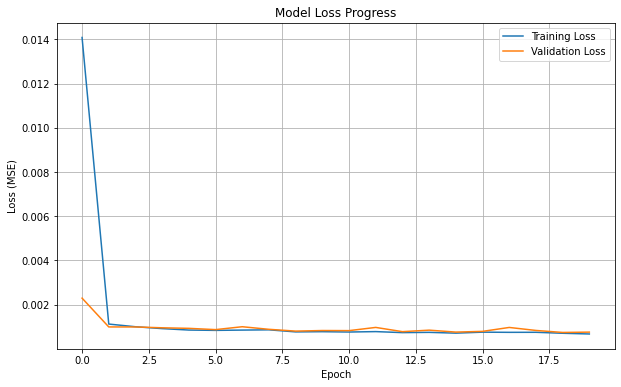

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progress')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()